In [7]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent.parent 
print(project_root)
sys.path.append(str(project_root))


/media/l1t-w1n/E/footwork/FootWork


In [8]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict

class BinaryFootballMatchPredictor:
    def __init__(self, data: pd.DataFrame):
        """
        Initialize the predictor for binary classification (Home Win vs Away Win).
        First checks and processes the target variable format.
        """
        self.original_data = data.copy()
        
        # First, let's check what values we have
        unique_values = data['target_result'].unique()
        print("Original target values:", unique_values)
        
        # Convert numerical target_result back to categorical if needed
        if data['target_result'].dtype in ['int64', 'float64']:
            # Assuming 0 = Away Win, 1 = Draw, 2 = Home Win after encoding
            value_map = {0: 'AwayWin', 1: 'Draw', 2: 'HomeWin'}
            self.data = data.copy()
            self.data['target_result'] = self.data['target_result'].map(value_map)
        else:
            self.data = data.copy()
        
        # Filter out draws
        self.data = self.data[self.data['target_result'].isin(['HomeWin', 'AwayWin'])]
        
        # Convert to binary
        self.data['target_binary'] = (self.data['target_result'] == 'HomeWin').astype(int)
        
        # Print class distribution
        total_matches = len(self.data)
        if total_matches > 0:
            home_wins = (self.data['target_binary'] == 1).sum()
            away_wins = (self.data['target_binary'] == 0).sum()
            
            print("\nDataset Overview after removing draws:")
            print(f"Total matches: {total_matches}")
            print(f"Home wins: {home_wins} ({home_wins/total_matches*100:.1f}%)")
            print(f"Away wins: {away_wins} ({away_wins/total_matches*100:.1f}%)")
        else:
            raise ValueError("No matches found after filtering. Please check the target_result values.")
        
        self.model = None
        self.feature_importance = None
        self.prepare_features()
    
    def prepare_features(self):
        """
        Prepare features for binary prediction, organizing them into meaningful categories
        that capture different aspects of team performance and match conditions.
        """
        feature_categories = {
            'performance_stats': ['wins', 'draws', 'losses', 'points_per_game'],
            'goal_stats': ['avg_goals_scored', 'avg_goals_conceded', 'avg_goal_diff'],
            'recent_form': ['recent_goals_scored', 'recent_goals_conceded', 
                          'recent_points_per_game', 'recent_clean_sheets'],
            'match_stats': ['shot_conversion_rate', 'shots_on_target_ratio', 
                          'avg_shots_per_game', 'avg_shots_on_target', 
                          'avg_possession', 'possession_efficiency'],
            'set_pieces': ['avg_corners_for', 'corner_efficiency'],
            'discipline': ['avg_fouls_committed', 'avg_yellows', 'avg_reds', 
                         'cards_first_half_ratio'],
            'venue_stats': ['venue_win_ratio', 'venue_goals_avg', 'venue_conceded_avg', 
                          'clean_sheets_ratio', 'scoring_ratio'],
            'temporal': ['date_year', 'date_month', 'date_day', 'date_dayofweek']
        }
        
        self.feature_columns = []
        for category, patterns in feature_categories.items():
            for pattern in patterns:
                matching_columns = [col for col in self.data.columns 
                                  if pattern in col and not col.startswith('target_')]
                self.feature_columns.extend(matching_columns)
        
        self.feature_columns = list(set(self.feature_columns))
        
        print(f"\nSelected {len(self.feature_columns)} features for prediction")
        print("\nFeature categories included:")
        for category in feature_categories:
            category_columns = [col for col in self.feature_columns 
                              if any(pattern in col for pattern in feature_categories[category])]
            print(f"{category}: {len(category_columns)} features")
    
    def split_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Split the data into training and testing sets, maintaining class balance.
        """
        X = self.data[self.feature_columns]
        y = self.data['target_binary']
        
        return train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=y
        )
    
    def train_model(self, verbose: bool = True) -> Tuple[np.ndarray, np.ndarray]:
        """
        Train the XGBoost model for binary classification.
        Uses appropriate parameters for binary prediction and class balancing.
        """
        X_train, X_test, y_train, y_test = self.split_data()
        
        # Initialize model with binary classification settings
        self.model = xgb.XGBClassifier(
            max_depth=6,
            learning_rate=0.1,
            n_estimators=1000,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',  # Changed to binary classification
            eval_metric='logloss',        # Appropriate for binary classification
            early_stopping_rounds=20,
            random_state=42,
            use_label_encoder=False
        )
        
        # Train the model
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=verbose
        )
        
        # Calculate feature importance
        self.feature_importance = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return X_test, y_test
    
    def evaluate_model(self, X_test: np.ndarray, y_test: np.ndarray):
        """
        Evaluate the binary classification model with appropriate metrics.
        """
        y_pred = self.model.predict(X_test)
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, 
                                  target_names=['Away Win', 'Home Win']))
        
        # Create confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Away Win', 'Home Win'],
                   yticklabels=['Away Win', 'Home Win'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Outcome')
        plt.ylabel('Actual Outcome')
        plt.show()
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = self.feature_importance.head(20)
        sns.barplot(data=top_features, x='importance', y='feature')
        plt.title('Top 20 Most Important Features')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()

def train_binary_predictor(data: pd.DataFrame) -> BinaryFootballMatchPredictor:
    """
    Complete pipeline for training and evaluating the binary match predictor.
    """
    predictor = BinaryFootballMatchPredictor(data)
    
    print("\nTraining model...")
    X_test, y_test = predictor.train_model()
    
    print("\nEvaluating model performance...")
    predictor.evaluate_model(X_test, y_test)
    
    return predictor


Original target values: [2 1 0]

Dataset Overview after removing draws:
Total matches: 18207
Home wins: 11086 (60.9%)
Away wins: 7121 (39.1%)

Selected 60 features for prediction

Feature categories included:
performance_stats: 10 features
goal_stats: 6 features
recent_form: 8 features
match_stats: 12 features
set_pieces: 4 features
discipline: 8 features
venue_stats: 10 features
temporal: 4 features

Training model...
[0]	validation_0-logloss:0.65495
[1]	validation_0-logloss:0.64355
[2]	validation_0-logloss:0.63408
[3]	validation_0-logloss:0.62627
[4]	validation_0-logloss:0.61953
[5]	validation_0-logloss:0.61373
[6]	validation_0-logloss:0.60885
[7]	validation_0-logloss:0.60549
[8]	validation_0-logloss:0.60225
[9]	validation_0-logloss:0.59965
[10]	validation_0-logloss:0.59680


/media/l1t-w1n/E/footwork/FootWork/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:40:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-logloss:0.59518
[12]	validation_0-logloss:0.59395
[13]	validation_0-logloss:0.59246
[14]	validation_0-logloss:0.59126
[15]	validation_0-logloss:0.58997
[16]	validation_0-logloss:0.58864
[17]	validation_0-logloss:0.58770
[18]	validation_0-logloss:0.58690
[19]	validation_0-logloss:0.58705
[20]	validation_0-logloss:0.58644
[21]	validation_0-logloss:0.58590
[22]	validation_0-logloss:0.58536
[23]	validation_0-logloss:0.58516
[24]	validation_0-logloss:0.58464
[25]	validation_0-logloss:0.58433
[26]	validation_0-logloss:0.58403
[27]	validation_0-logloss:0.58381
[28]	validation_0-logloss:0.58367
[29]	validation_0-logloss:0.58369
[30]	validation_0-logloss:0.58404
[31]	validation_0-logloss:0.58427
[32]	validation_0-logloss:0.58411
[33]	validation_0-logloss:0.58415
[34]	validation_0-logloss:0.58455
[35]	validation_0-logloss:0.58501
[36]	validation_0-logloss:0.58565
[37]	validation_0-logloss:0.58556
[38]	validation_0-logloss:0.58580
[39]	validation_0-logloss:0.58624
[40]	validatio

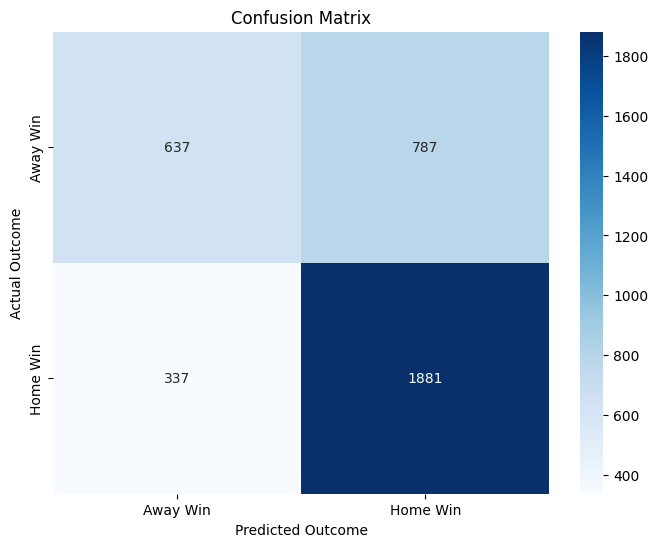

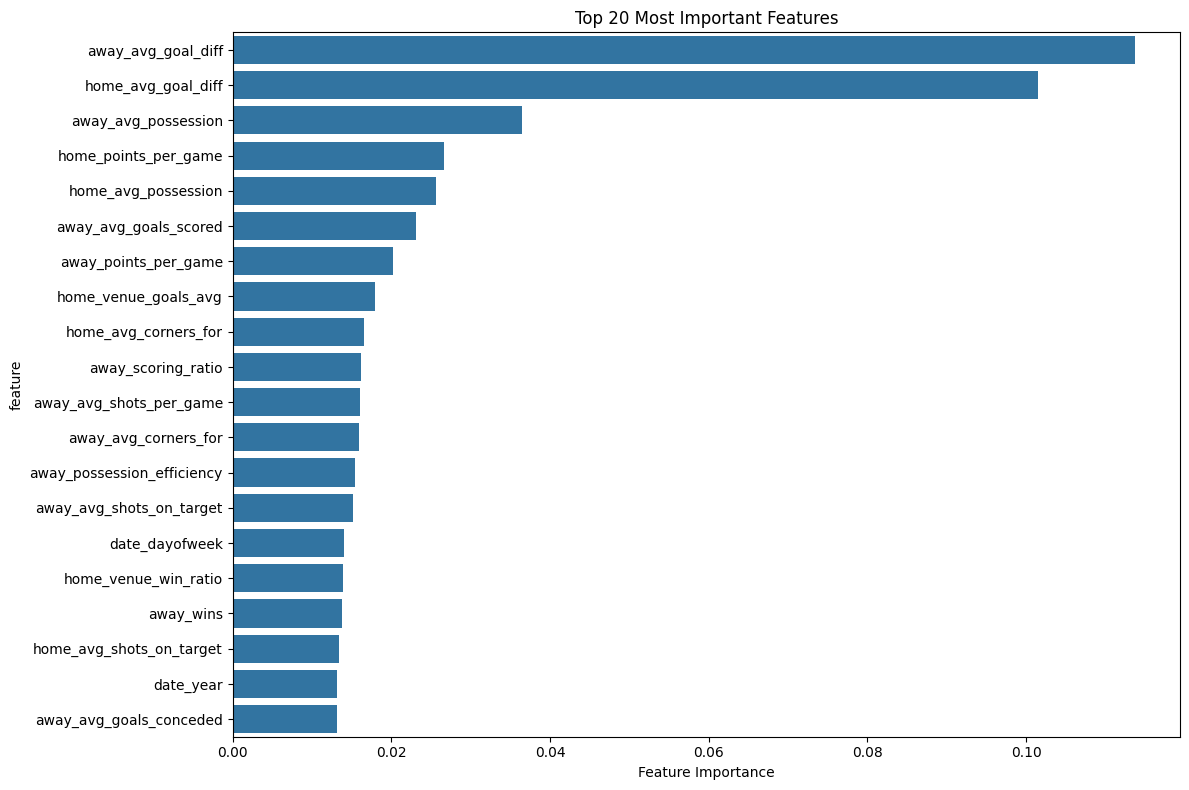

In [9]:
data = pd.read_csv(f"{project_root}/data/all_leagues_deskewed_normalized.csv")
predictor = train_binary_predictor(data)